# Anomaly Detection and Recommender Systems

This notebook implements the eighth exercise from Andrew Ng’s Machine Learning Course on Coursera.

## Anomaly Detection

An anomaly detection algorithm will be implemented to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While the servers were operating, m=307 examples of how they were behaving were collected, and thus having an unlabeled dataset {x(1),…,x(m)}. It is suspected that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

A Gaussian model will be used to detect anomalous examples in the dataset. First, a 2D dataset will allow to visualize what the algorithm is doing. On that dataset a Gaussian distribution will be fitted in order to find values that have very low probability and hence can be considered anomalies.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

### Loading the Dataset

In [2]:
data = loadmat('Data/ex8data1.mat')
X = data["X"]
Xval = data["Xval"]
yval = data["yval"]

In [3]:
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

### Visualizing the Dataset

Text(0, 0.5, 'Throughput mbps')

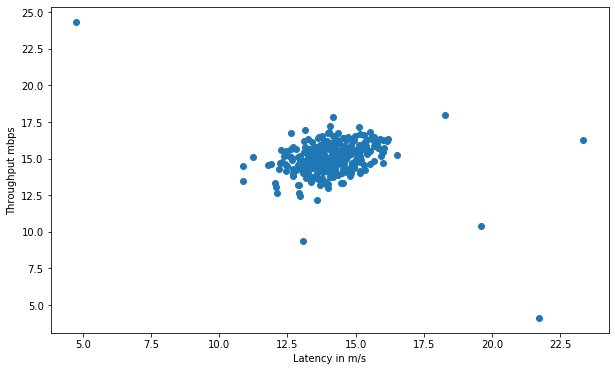

In [4]:
plt.figure(figsize = (10,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('Latency in m/s')
plt.ylabel('Throughput mbps')

Clearly we have some outliers. Let's see if the gaussian model can get these anomalies!

### Estimating Parameters for a Gaussian model

Let's estimate the mean and variance of the dataset before finding out the features that have low probability(posibly anomalies). The next step is to implement a gaussian distribution function to find the probability with the mean and variance from previous step. 

In [5]:
def estimateGaussian(X):
    """
    Estimates the parameters (mean, variance) of a
    Gaussian distribution using the data in X.
    Input:
        X     : array(# of training examples m, # of features n)
    Output:
        mu    : array(# of features n, 1)
        sigma : array(# of features n, 1)
    """
   
    m, n = X.shape
    
    # Init mu and sigma.
    mu = np.zeros((n, 1))
    sigma = np.zeros((n, 1))
    
    mu = np.mean(X.T, axis = 1)
    mu = mu.reshape(mu.shape[0], -1) # n * 1
    sigma = np.var(X.T, axis = 1)
    sigma = sigma.reshape(sigma.shape[0], -1) # n * 1

    return mu, sigma

from scipy import stats
def gaussianDistribution(X, mu, Sigma):
    """
    calculate the probability that a data point belongs to a 
    normal distribution given some set of parameters.
    """
    p = np.zeros((X.shape[0], X.shape[1]))
    
    for i in range(X.shape[1]):
        p[:,i] = stats.norm(mu[i], sigma[i]).pdf(X[:,i])
    return p

### Selecting the Threshold, epsilon

Now that the Gaussian parameters have been implemented, it can be investigated which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in the dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. An algorithm will be implemented to select the threshold ε using the F1 score on a cross validation set.

In [6]:
def selectThreshold(yval, pval):
    """
    Finds the best threshold to use for selecting outliers
    based on the results from a validation set (pval) and
    the ground truth (yval).
    """
    # Init values.
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), stepsize):
        predictions = pval < epsilon
        
        tp = np.sum(np.logical_and(predictions == 1, yval == 1)).astype(float) # true positives
        fp = np.sum(np.logical_and(predictions == 1, yval == 0)).astype(float) # false positives
        fn = np.sum(np.logical_and(predictions == 0, yval == 1)).astype(float) # false negatives
        
        prec = tp / (tp + fp) # precision
        rec = tp / (tp + fn) # recall
        F1 = (2 * prec * rec) / (prec + rec) # F1 score
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

### Training and Evaluating Model

Now that the algorithm is implemented, lets apply the same on the dataset and check if anomalies are detected

In [7]:
# Estimate the parameters
mu, sigma = estimateGaussian(X)

mu.shape, sigma.shape

((2, 1), (2, 1))

In [8]:
# Training set. 
p = gaussianDistribution(X, mu, sigma)

p.shape

(307, 2)

In [9]:
# Cross-validation set.
pval = gaussianDistribution(Xval, mu, sigma)

pval.shape

(307, 2)

In [10]:
# Find the best threshold.
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 on Cross Validation Set: {}'.format(F1))

Best epsilon found using cross-validation: 0.009566706005956842
Best F1 on Cross Validation Set: 0.7142857142857143


/home/supriya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Finally, we can apply the threshold to the data set and visualize the results.

Text(0, 0.5, 'Throughput mbps')

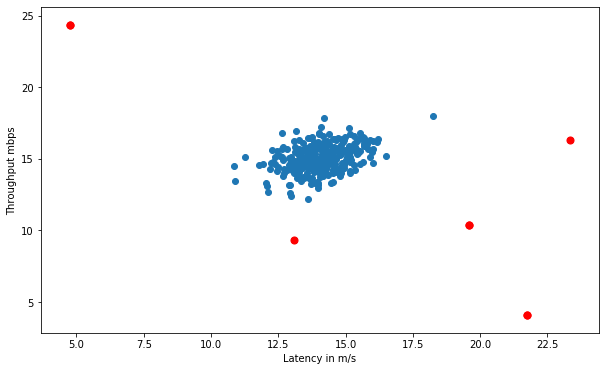

In [11]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)

plt.figure(figsize = (10,6))
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')

plt.xlabel('Latency in m/s')
plt.ylabel('Throughput mbps')

The points in red are the ones that were flagged as outliers. Visually these seem pretty reasonable. 

In [12]:
print('# Outliers found: {}'.format(np.sum(outliers[1]) + 1)) #index starts from 0!

# Outliers found: 5


## Recommender System

Part-2 of the exercise involves building a recommender system using collaberative filtering algorithm to a dataset of movie ratings.

### Movie Ratings Dataset

The dataset consists of ratings on a scale of 1 to 5. It has 943 users and 1682 movies. The variable Y (num_movies x num_users matrix) stores the ratings y(i,j) (from 1 to 5). The variable R is a binary-valued indicator matrix, where R(i,j)=1 if user j gave a rating to movie i, and R(i,j)=0 otherwise.  
  
The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with R(i,j)=0. This will allow to recommend the movies with the highest predicted ratings to the user.

In [13]:
movie_data = loadmat('Data/ex8_movies.mat')

In [14]:
Y = movie_data['Y']
R = movie_data['R']

Y.shape, R.shape

((1682, 943), (1682, 943))

### Collaberative filtering algorithm implementation

In [15]:
def cofiCostFunction(params, Y, R, num_features, lambda_coef):
    """
    Returns the cost and gradient for
    the collaborative filtering problem.
    Input:
        params      : array(num_movies x num_features + num_users x num_features)
        Y           : array(num_movies, num_users)
        R           : array(num_movies, num_users)
        num_features: int
        lambda_coef : float
    Output:
        J           : float
        grad        : array(num_movies x num_features + num_users x num_features)
    """
    
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    
    # Unfold X and theta from Params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Init values
    J = 0
    X_grad = np.zeros(X.shape)
    theta_grad = np.zeros(theta.shape)
    
    # regularization terms
    reg_term = (lambda_coef / 2) * (np.sum(np.square(theta)) + np.sum(np.square(X)))
    
    # error
    error = np.dot(X, theta.T) - Y
    sq_error = np.square(error)
    
    # Cost
    J = (1 / 2) * np.sum(sq_error * R) + reg_term
    
    # gradients
    X_grad = np.dot(error * R, theta) + lambda_coef * X
    theta_grad = np.dot((error * R).T, X) + lambda_coef * theta
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    
    return J, grad

### Movie Recommendations

Create your own movie ratings so you can use the model to generate personalized recommendations. The file 'movie_ids.txt' contains list of all movies and their number(id) mapped to the 'movie_data' dataset. Assign your own ratings for some of the movies which you would have watched to this dataset. Check the file movie_idx.txt for id of each movie in the dataset.   
For example, Toy Story (1995) has ID 0. so to rate it "4", set: my_ratings[0] = 4.

In [16]:
# read the text file and move the contents to a list

def loadMovieList():
    
    # Read the fixed movie list.
    with open('Data/movie_ids.txt', encoding = "ISO-8859-1") as f:
        movieList = []
        for line in f:
            movieName = line.split()[1:]
            movieList.append(" ".join(movieName))

    return movieList

In [17]:
movieList = loadMovieList()

# Initialize ratings.
my_ratings = np.zeros((1682, 1))

# Add your ratings 
my_ratings[63] = 5
my_ratings[81] = 4
my_ratings[93] = 5
my_ratings[116] = 4
my_ratings[120] = 3
my_ratings[143] = 5
my_ratings[119] = 4
my_ratings[299] = 3
my_ratings[317] = 4
my_ratings[553] = 2
my_ratings[941] = 1
my_ratings[1178] = 2
my_ratings[1250] = 1

print('My ratings:\n')
for i, rating in enumerate(my_ratings):
    if rating > 0: 
        print('Rated {} for {}'.format(rating[0], movieList[i]))

My ratings:

Rated 5.0 for Shawshank Redemption, The (1994)
Rated 4.0 for Jurassic Park (1993)
Rated 5.0 for Home Alone (1990)
Rated 4.0 for Rock, The (1996)
Rated 4.0 for Striptease (1996)
Rated 3.0 for Independence Day (ID4) (1996)
Rated 5.0 for Die Hard (1988)
Rated 3.0 for Air Force One (1997)
Rated 4.0 for Schindler's List (1993)
Rated 2.0 for Waterworld (1995)
Rated 1.0 for What's Love Got to Do with It (1993)
Rated 2.0 for Man of the House (1995)
Rated 1.0 for A Chef in Love (1996)


### Recommender System learning

Let's train the collaborative filtering model. First, we need to normalize the ratings(Y) and then run the optimization routine using our cost function 'cofiCostFunction', parameter vector (X, theta) at input.

In [18]:
from scipy.optimize import minimize

In [19]:
#Add my ratings to the data matrix.
Y = np.append(Y, my_ratings, axis = 1)
R = np.append(R, my_ratings != 0, axis = 1)

# Get useful values.
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Let's normalize
Ymean = np.zeros((num_movies, 1))
Ynorm = np.zeros((num_movies, num_users))

for i in range(num_movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

In [20]:
# Set initial parameters (Theta, X).
X = np.random.randn(num_movies, num_features)
theta = np.random.randn(num_users, num_features)

initial_params = np.concatenate((np.ravel(X), np.ravel(theta)))

# Set regularization.
lambda_coef = 10

# Optimize.
fmin = minimize(fun = cofiCostFunction, x0 = initial_params, args = (Ynorm, R, num_features, lambda_coef), method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38957.70140788267
     jac: array([-0.09856893,  0.01801755, -0.00463038, ..., -0.00659441,
        0.00530204,  0.00093459])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 149
     nit: 100
    njev: 149
  status: 1
 success: False
       x: array([ 1.16705865, -0.0251449 ,  0.09196431, ..., -0.13119354,
       -0.00307313, -0.0476326 ])

Since everything was unrolled for the optimization routine to work properly, we need to reshape our parameters back to their original dimensions.

In [21]:
result = fmin.x

X = result[:num_movies * num_features].reshape(num_movies, num_features)
theta = result[num_movies * num_features:].reshape(num_users, num_features)

X.shape, theta.shape

((1682, 10), (944, 10))

### Recommendations for me

Our trained parameters are now in X and theta. We can use these to create some movie recommendations based on my_ratings.

In [22]:
# get the predictions

pred = np.dot(X, theta.T)

my_predictions = pred[:, -1] + Ymean.flatten() # choose a single column
my_predictions

array([3.7219158 , 3.20061611, 3.06775999, ..., 1.99999843, 2.99999771,
       3.0000022 ])

In [23]:
pred.shape, my_predictions.shape

((1682, 944), (1682,))

That gives us an ordered list of the top ratings, but we don't know the movies for which the ratings are predicted. Let's use argsort to get the locations(movies to which predicted rating corresponds to) at these indicies.

In [24]:
movieList = loadMovieList()

idx = my_predictions.argsort()[::-1] # reverse sort by index

print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {} for movie {}'.format(my_predictions[j], movieList[j]))

Top 10 movie predictions:
Predicted rating of 5.000009543830491 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicted rating of 5.000004997116824 for movie Prefontaine (1997)
Predicted rating of 5.000003033924966 for movie Star Kid (1997)
Predicted rating of 5.0000011043866746 for movie Santa with Muscles (1996)
Predicted rating of 5.0000005984073175 for movie Saint of Fort Washington, The (1993)
Predicted rating of 5.000000045519126 for movie Aiqing wansui (1994)
Predicted rating of 4.999999155700832 for movie Someone Else's America (1995)
Predicted rating of 4.999998266049712 for movie They Made Me a Criminal (1939)
Predicted rating of 4.9999976816302985 for movie Marlene Dietrich: Shadow and Light (1996)
Predicted rating of 4.9999956145148845 for movie Great Day in Harlem, A (1994)
